In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PSID
from PSID.evaluation import evalPrediction
from src.cross_validation_PSID import cross_validation, cross_validation_split
from src.explore_state_dimensions import plot_explorations
from src.explore_state_dimensions import explore_latent_behavior_dims
%load_ext autoreload
%autoreload 2

# explore dimensions of behaviorally relevant dynamics
# in here all latent space dimensions will be used to prioritize behavior, meaning n1 = nx

PATH_FEATURES = "/home/lauraflyra/Documents/BCCN/Lab_Rotation_USC/Code/Data/py_neuromodulation_derivatives/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_FEATURES.csv"
data_features = pd.read_csv(PATH_FEATURES, index_col=0)

# Start with bandpass features

In [2]:
feature_df_bandpass = pd.concat([data_features.filter(like='LFP'),data_features.filter(like='ECOG')], axis = 1).filter(like='bandpass_activity').to_numpy()
behavior_df = data_features["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)

In [4]:
pd.concat([data_features.filter(like='LFP'),data_features.filter(like='ECOG')], axis = 1).shape

(2810, 587)

In [13]:
K_FOLDS = 5
N_DIMS = 15

Cross validation results from XGBOOST with $R^{2}$ for bandpass features:
mean $R^{2}$ = 0.643
std = 0.051

In [14]:
xgboost_mean_r2_bandpass = 0.643
xgboost_std_r2_bandpass = 0.051

In [15]:
i_s = [30, 40, 50]
evals = []
behavior_dims_latents =[]
for i in i_s:
    eval,behavior_dims_latent = explore_latent_behavior_dims(neural = feature_df_bandpass, behavior= behavior_df, k_folds=5, n_dims=15, max_dim=30,i=i, cv_eval='R2')
    evals.append(eval)
    behavior_dims_latents.append(behavior_dims_latent)


Behavior decoding evaluation:
  PSID => 0.253
Behavior decoding evaluation:
  PSID => 0.412
Behavior decoding evaluation:
  PSID => 0.387
Behavior decoding evaluation:
  PSID => 0.397
Behavior decoding evaluation:
  PSID => 0.504
Behavior decoding evaluation:
  PSID => 0.605
Behavior decoding evaluation:
  PSID => 0.678
Behavior decoding evaluation:
  PSID => 0.642
Behavior decoding evaluation:
  PSID => 0.608
Behavior decoding evaluation:
  PSID => 0.631
Behavior decoding evaluation:
  PSID => 0.618
Behavior decoding evaluation:
  PSID => 0.708
Behavior decoding evaluation:
  PSID => 0.663
Behavior decoding evaluation:
  PSID => 0.608
Behavior decoding evaluation:
  PSID => 0.645
Behavior decoding evaluation:
  PSID => 0.603
Behavior decoding evaluation:
  PSID => 0.698
Behavior decoding evaluation:
  PSID => 0.683
Behavior decoding evaluation:
  PSID => 0.6
Behavior decoding evaluation:
  PSID => 0.631
Behavior decoding evaluation:
  PSID => 0.609
Behavior decoding evaluation:
  PSID

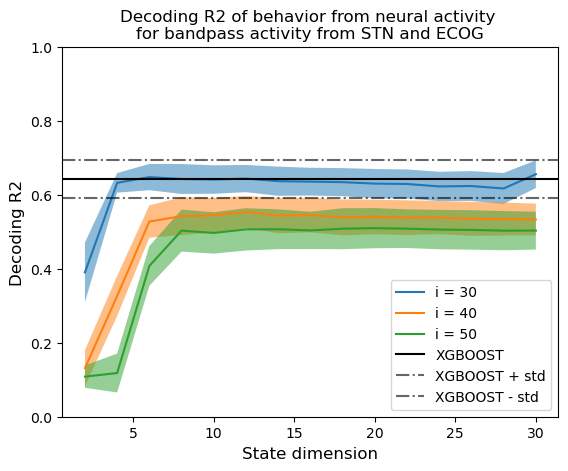

In [18]:
metrics = "R2"
feature_type = "bandpass activity"
channel_type = 'STN and ECOG'
for j in range(len(i_s)):
        plt.plot(behavior_dims_latents[j], np.mean(evals[j], axis=1), label="i = {}".format(i_s[j]))
        plt.fill_between(behavior_dims_latents[j],
                         np.mean(evals[j], axis=1) - np.std(evals[j], axis=1),
                         np.mean(evals[j], axis=1) + np.std(evals[j], axis=1),
                         alpha=0.5)
plt.axhline(y=xgboost_mean_r2_bandpass, color='black', linestyle='-', label='XGBOOST')
plt.axhline(y=xgboost_mean_r2_bandpass + xgboost_std_r2_bandpass, color='black', linestyle='-.',
            label='XGBOOST + std', alpha=0.6)
plt.axhline(y=xgboost_mean_r2_bandpass - xgboost_std_r2_bandpass, color='black', linestyle='-.',
            label='XGBOOST - std', alpha=0.6)
plt.ylim(0, 1)
plt.ylabel("Decoding " + metrics, fontsize=12)
plt.xlabel("State dimension", fontsize=12)
plt.legend()
plt.title(
    "Decoding " + metrics + " of behavior from neural activity \nfor " + feature_type + " from " + channel_type,
    fontsize=12)
plt.show()

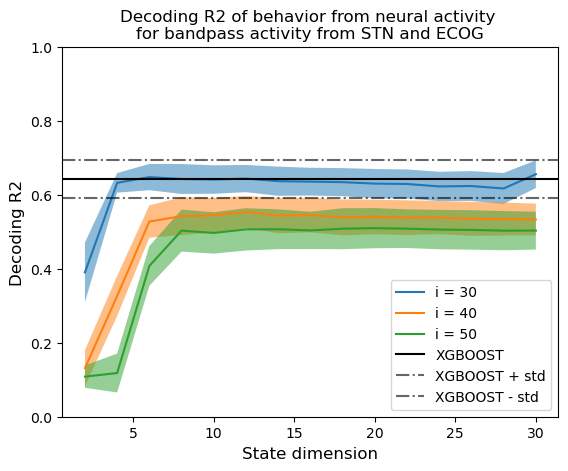

In [17]:
plot_explorations(evals, behavior_dims_latent, i_s,xgboost_mean=xgboost_mean_r2_bandpass, xgboost_std=xgboost_std_r2_bandpass)

# Explore FFT features

In [4]:
feature_df_fft = pd.concat([data_features.filter(like='LFP'),data_features.filter(like='ECOG')], axis = 1).filter(like='fft').to_numpy()
behavior_df = data_features["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)

Cross validation results from XGBOOST with $R^{2}$ for FFT features:
mean $R^{2}$ = 0.77
std = 0.06

In [5]:
xgboost_mean_r2_fft = 0.77
xgboost_std_r2_fft = 0.03

In [6]:
i_s = [30, 40, 50]
evals_fft = []
for i in i_s:
    eval,behavior_dims_latent = explore_latent_behavior_dims(neural = feature_df_fft, behavior= behavior_df, k_folds=5, n_dims=15, max_dim=30,i=i, cv_eval='R2')
    evals_fft.append(eval)


Behavior decoding evaluation:
  PSID => 0.164
Behavior decoding evaluation:
  PSID => 0.14
Behavior decoding evaluation:
  PSID => 0.13
Behavior decoding evaluation:
  PSID => 0.017
Behavior decoding evaluation:
  PSID => 0.242
Behavior decoding evaluation:
  PSID => 0.431
Behavior decoding evaluation:
  PSID => 0.404
Behavior decoding evaluation:
  PSID => 0.396
Behavior decoding evaluation:
  PSID => 0.349
Behavior decoding evaluation:
  PSID => 0.295
Behavior decoding evaluation:
  PSID => 0.51
Behavior decoding evaluation:
  PSID => 0.539
Behavior decoding evaluation:
  PSID => 0.495
Behavior decoding evaluation:
  PSID => 0.503
Behavior decoding evaluation:
  PSID => 0.438
Behavior decoding evaluation:
  PSID => 0.519
Behavior decoding evaluation:
  PSID => 0.528
Behavior decoding evaluation:
  PSID => 0.504
Behavior decoding evaluation:
  PSID => 0.521
Behavior decoding evaluation:
  PSID => 0.454
Behavior decoding evaluation:
  PSID => 0.506
Behavior decoding evaluation:
  PSID 

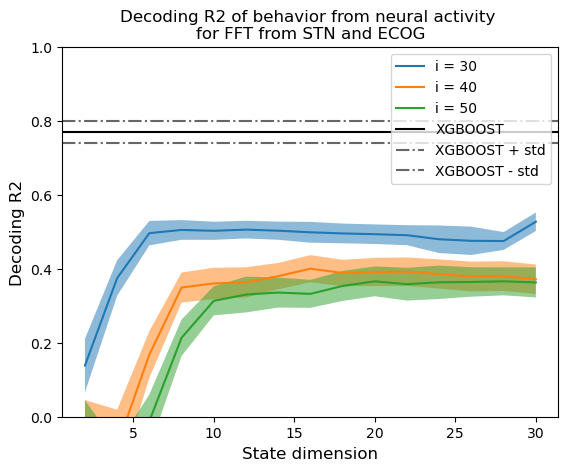

In [7]:
plot_explorations(evals_fft, behavior_dims_latent, i_s,xgboost_mean=xgboost_mean_r2_fft, xgboost_std=xgboost_std_r2_fft, feature_type='FFT')

# Explore Sharpwave features

In [8]:
feature_df_sw = data_features.filter(like='ECOG').filter(like='Sharpwave_Mean').to_numpy()[1:]
behavior_df = data_features["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)[1:]

In [8]:
data_features.filter(like='ECOG_RIGHT_4').filter(like='Sharpwave_Mean').keys()

Index(['ECOG_RIGHT_4-avgref_Sharpwave_Mean_peak_left_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_peak_right_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_trough_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_width_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_prominence_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_interval_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_decay_time_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_rise_time_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_sharpness_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_rise_steepness_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_decay_steepness_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_slope_ratio_range_5_80',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_peak_left_range_5_30',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_peak_right_range_5_30',
       'ECOG_RIGHT_4-avgref_Sharpwave_Mean_trough_range_5_30',
    

In [ ]:
i_s = [30, 40, 50]
evals_sw = []
for i in i_s:
    eval,behavior_dims_latent_sw = explore_latent_behavior_dims(neural = feature_df_sw, behavior= behavior_df, k_folds=5, n_dims=15, max_dim=30,i=i, cv_eval='R2')
    evals_sw.append(eval)


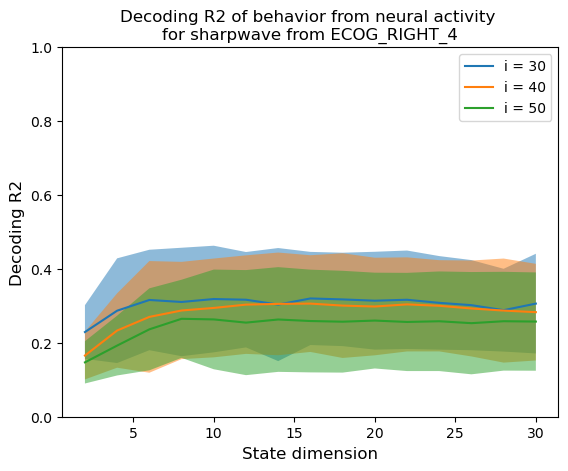

In [6]:
plot_explorations(evals_sw, behavior_dims_latent_sw, i_s,plot_xgboost=False, feature_type='sharpwave',channel_type='ECOG_RIGHT_4')

# Explore bursts

In [9]:
feature_df_burst = pd.concat([data_features.filter(like='LFP'),data_features.filter(like='ECOG')], axis = 1).filter(like='bursts_low beta').to_numpy()[1:]
behavior_df = data_features["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)[1:]

In [10]:
i_s = [30, 40, 50]
evals_burst = []
for i in i_s:
    eval,behavior_dims_latent = explore_latent_behavior_dims(neural = feature_df_burst, behavior= behavior_df, k_folds=5, n_dims=15, max_dim=30,i=i, cv_eval='R2')
    evals_burst.append(eval)


Behavior decoding evaluation:
  PSID => 0.0512
Behavior decoding evaluation:
  PSID => 0.035
Behavior decoding evaluation:
  PSID => 0.104
Behavior decoding evaluation:
  PSID => 0.0747
Behavior decoding evaluation:
  PSID => 0.123
Behavior decoding evaluation:
  PSID => -0.00271
Behavior decoding evaluation:
  PSID => -0.0222
Behavior decoding evaluation:
  PSID => 0.171
Behavior decoding evaluation:
  PSID => 0.15
Behavior decoding evaluation:
  PSID => 0.116
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0309
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0117
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.178
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.196
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.135
Behavior decoding evaluation:
  PSID => 0.0124
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0133
Behavior decoding evaluation:
  PSID => 0.206
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.208
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.164
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.018
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.00366
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.191
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.202
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.162
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.13
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0203
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.188
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.208
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.146
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0595
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0279
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.189
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.202
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.149
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0431
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0207
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.186
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.206
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.164
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0336
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0138
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.173
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.197
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.147
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0122
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0116
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.17
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.198
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.151
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0515
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0127
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.183
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.2
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.152
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0243
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.00668
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.184
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.18
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.137
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.042
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.000292
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.183
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.177
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.000283
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.046
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.00024
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.000644
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.000398
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.000283
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.123
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0369
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.151
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.182
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.112
Behavior decoding evaluation:
  PSID => 0.036
Behavior decoding evaluation:
  PSID => 0.0392
Behavior decoding evaluation:
  PSID => 0.11
Behavior decoding evaluation:
  PSID => 0.104
Behavior decoding evaluation:
  PSID => 0.119
Behavior decoding evaluation:
  PSID => -0.0291
Behavior decoding evaluation:
  PSID => -0.0349
Behavior decoding evaluation:
  PSID => 0.0931
Behavior decoding evaluation:
  PSID => 0.12
Behavior decoding evaluation:
  PSID => 0.0853
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.172
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0702
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.115
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.159
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0972
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0882
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.031
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.153
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.189
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.13
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.071
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0119
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.149
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.205
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.127
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0839
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.00519
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0816
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.216
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.165
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0592
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.00995
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.138
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.21
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.153
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.111
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.00817
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.142
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.22
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.151
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.102
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0258
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.146
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.2
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.148
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0658
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0299
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.152
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.202
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.138
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.183
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -8.74e-05
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.143
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.204
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.137
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0898
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0114
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.131
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.205
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.146
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.145
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.023
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.111
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.203
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.143
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.101
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0213
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.133
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.201
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.141
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.208
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.017
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.149
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.203
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.145
Behavior decoding evaluation:
  PSID => -0.0607
Behavior decoding evaluation:
  PSID => 0.00658
Behavior decoding evaluation:
  PSID => 0.0729
Behavior decoding evaluation:
  PSID => 0.0934
Behavior decoding evaluation:
  PSID => -0.0417
Behavior decoding evaluation:
  PSID => -0.186
Behavior decoding evaluation:
  PSID => -0.145
Behavior decoding evaluation:
  PSID => -0.0471
Behavior decoding evaluation:
  PSID => -0.0109
Behavior decoding evaluation:
  PSID => -0.197
Behavior decoding evaluation:
  PSID => -0.0793
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.126
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.00962
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0846
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0662
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.452
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0809
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0237
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.107
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.034
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.31
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.1
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0307
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.116
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0383
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.3
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0943
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0238
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.138
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0298
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.315
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.145
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.00409
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.113
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.021
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.351
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.145
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.0174
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.12
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0432
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.332
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.124
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.00363
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.135
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0125
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.34
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.142
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.00713
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.125
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0193
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.34
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.142
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0175
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.11
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0161
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.369
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.147
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.00237
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.111
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0174
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.364
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.143
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0021
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.123
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0182
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.361
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.134
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.00827
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.123
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0184
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.371
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.139
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.00267
Could not solve DARE: The associated symplectic pencil has eigenvaluestoo close to the unit circle


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => 0.122
Could not solve DARE: Reordering of (A, B) failed because the transformed matrix pair (A, B) would be too far from generalized Schur form; the problem is very ill-conditioned. (A, B) may have been partially reordered.


/home/lauraflyra/anaconda3/envs/Code/lib/python3.10/site-packages/PSID/LSSM.py:212: UserWarning: Steady state Kalman gain not available. Will perform non-steady-state Kalman.
  warnings.warn('Steady state Kalman gain not available. Will perform non-steady-state Kalman.')


Behavior decoding evaluation:
  PSID => -0.0117


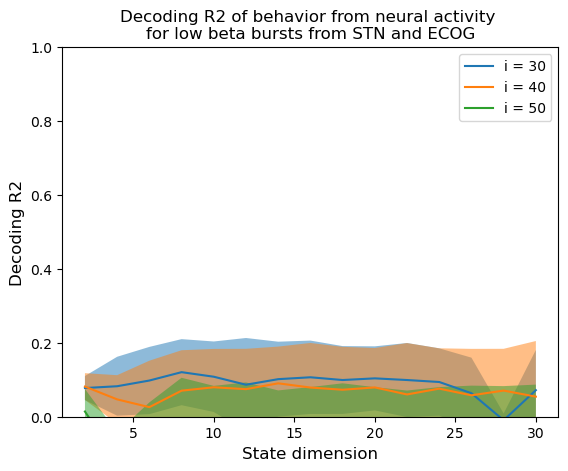

In [11]:
plot_explorations(evals_burst, behavior_dims_latent, i_s,plot_xgboost=False, feature_type='low beta bursts')

# Explore with sub-003

In [2]:
PATH_FEATURES_S3 = "/home/lauraflyra/Documents/BCCN/Lab_Rotation_USC/Code/Data/py_neuromodulation_derivatives/sub-003_ses-right_task-force_run-4/sub-003_ses-right_task-force_run-4_FEATURES.csv"
data_features_s3 = pd.read_csv(PATH_FEATURES_S3, index_col=0)

In [3]:
feature_df_s3 = data_features_s3.filter(like='ECOG_RIGHT').filter(like='bandpass_activity').to_numpy()[1:]
behavior_s3 = data_features_s3["MOV_LEFT_CLEAN"].to_numpy().reshape(-1, 1)[1:]

i_s = [30, 40, 50]
evals_s3 = []
for i in i_s:
    eval, behavior_dims_latent_s3 = explore_latent_behavior_dims(neural=feature_df_s3, behavior=behavior_s3, k_folds=3,
                                                              n_dims=10, max_dim=30, i=i, cv_eval='R2')
    evals_s3.append(eval)

Behavior decoding evaluation:
  PSID => -0.0268
Behavior decoding evaluation:
  PSID => -0.222
Behavior decoding evaluation:
  PSID => -0.0904
Behavior decoding evaluation:
  PSID => -0.116
Behavior decoding evaluation:
  PSID => -0.741
Behavior decoding evaluation:
  PSID => -0.261
Behavior decoding evaluation:
  PSID => -0.0928
Behavior decoding evaluation:
  PSID => -0.761
Behavior decoding evaluation:
  PSID => -0.241
Behavior decoding evaluation:
  PSID => -0.0613
Behavior decoding evaluation:
  PSID => -0.792
Behavior decoding evaluation:
  PSID => -0.25
Behavior decoding evaluation:
  PSID => -0.0662
Behavior decoding evaluation:
  PSID => -0.813
Behavior decoding evaluation:
  PSID => -0.256
Behavior decoding evaluation:
  PSID => -0.0778
Behavior decoding evaluation:
  PSID => -0.801
Behavior decoding evaluation:
  PSID => -0.251


KeyboardInterrupt: 

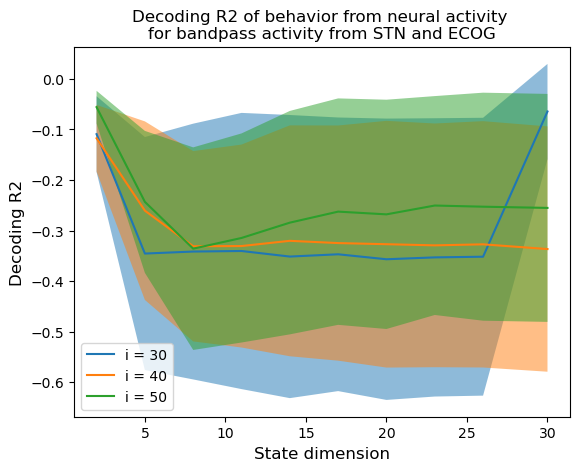

In [9]:
plot_explorations(evals_s3, behavior_dims_latent_s3, i_s,plot_xgboost=False, feature_type='bandpass activity')